In [31]:
import mujoco
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = mujoco.MjModel.from_xml_path("/home/luangb/Documents/TCC/Kuka_RL_Control/environment.xml")
data = mujoco.MjData(model)

In [4]:
data.ctrl[0] = .5 

In [59]:
def step_input():
    mujoco.mj_resetData(model, data)

    data.actuator("a6_pos").ctrl = np.pi
    data.actuator("a6_vel").ctrl = 5.0
    result = {"qpos":[data.joint("joint_a6").qpos], "qvel":[data.joint("joint_a6").qvel], "ctrlpos":[data.ctrl[0]], "ctrlvel":[data.ctrl[1]], "time":[data.time]}
    for _ in range(2000):
        mujoco.mj_step(model,data)
        result["qpos"].append(data.qpos[0])
        result["qvel"].append(data.qvel[0])
        result["ctrlpos"].append(data.ctrl[0])
        result["ctrlvel"].append(data.ctrl[1])
        result["time"].append(data.time)
        if data.ctrl[1] and np.abs(data.qpos[0]-np.pi) < 0.01:
            data.ctrl[1]=0.0
    return result


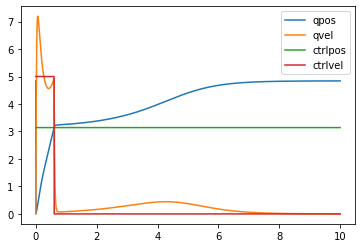

In [60]:
#plot 
result = step_input()
plt.plot(result["time"], result["qpos"], label="qpos")
plt.plot(result["time"], result["qvel"], label="qvel")
plt.plot(result["time"], result["ctrlpos"], label="ctrlpos")
plt.plot(result["time"], result["ctrlvel"], label="ctrlvel")
plt.legend()
plt.show()

In [56]:
def set_ks(kp,kv):
    xml_string=f"""<mujoco model="kuka_kr16_2">

    <asset>
        <mesh name="base_link" file="base_link.stl" />
        <mesh name="link_1" file="link_1.stl" />
        <mesh name="link_2" file="link_2.stl" />
        <mesh name="link_3" file="link_3.stl" />
        <mesh name="link_4" file="link_4.stl" />
        <mesh name="link_5" file="link_5.stl" />
        <mesh name="link_6" file="link_6.stl" />
        <mesh name="cestinho" file="cestinho.stl"  scale="0.001 0.001 0.001"/>
    </asset>


    <worldbody>
        <body name="base">
            <geom type="mesh" mesh="base_link" rgba="0.1 0.1 0.1 1" />
            <body name="link_1" pos="0 0 0.675" >
                <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                <!-- <joint name="joint_a1" pos="0 0 0" axis="0 0 1" limited="true" range="-3.22886 3.22886" /> -->
                <geom type="mesh" mesh="link_1" rgba="0.95 0.36 0.1 1"/>
                <body name="link_2" pos="0.26 0 0">
                    <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                    <!-- <joint name="joint_a2" pos="0 0 0" axis="0 1 0" limited="true" range="-2.70526 0.610865"  /> -->
                    <geom type="mesh" mesh="link_2" rgba="0.95 0.36 0.1 1"/>
                    <body name="link_3" pos="0.68 0 0">
                        <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                        <!-- <joint name="joint_a3" pos="0 0 0" axis="0 1 0" limited="true" range="-2.26893 2.68781" /> -->
                        <geom type="mesh" mesh="link_3" rgba="0.95 0.36 0.1 1"/>
                        <body name="link_4" pos="0.67 0 -0.035">
                            <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                            <!-- <joint name="joint_a4" pos="0 0 0" axis="-1 0 0" limited="true" range="-6.10865 6.10865"/> -->
                            <geom type="mesh" mesh="link_4" rgba="0.95 0.36 0.1 1" />
                            <body name="link_5" pos="0 0 0">
                                <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                                <!-- <joint name="joint_a5" pos="0 0 0" axis="0 1 0" limited="true" range="-2.26893 2.26893" /> -->
                                <geom type="mesh" mesh="link_5" rgba="0.95 0.36 0.1 1"/>
                                <body name="link_6" pos="0 0 0">
                                    <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                                    <joint name="joint_a6" pos="0 0 0" axis="-1 0 0" limited="true" range="-6.10865 6.10865"  />
                                    <geom type="mesh" mesh="link_6" rgba="0.95 0.36 0.1 1"/>
                                    <body name="cestinho" pos="0.155 0 0">
                                        <!-- <inertial pos="0 0 0" mass="0.000001" diaginertia="0.01 0.01 0.01" /> -->
                                        <geom type="mesh" mesh="cestinho" rgba="0.95 0.36 0.1 1" xyaxes="0 1 0 0 0 1"/>
                                    </body>
                                </body>
                            </body>
                        </body>
                    </body>
                </body>
            </body>
        </body>
    </worldbody>
    <actuator >
                <!-- <position name="a1_pos" joint="joint_a1" ctrllimited="true" ctrlrange="-3.22886 3.22886" gear="1" kp="1"/> -->
                <!-- <position name="a2_pos" joint="joint_a2" ctrllimited="true" ctrlrange="-2.70526 0.610865" gear="1" kp="1"/> -->
                <!-- <position name="a3_pos" joint="joint_a3" ctrllimited="true" ctrlrange="-2.26893 2.68781" gear="1" kp="1"/> -->
                <!-- <position name="a4_pos" joint="joint_a4" ctrllimited="true" ctrlrange="-6.10865 6.10865" gear="1" kp="1"/> -->
                <!-- <position name="a5_pos" joint="joint_a5" ctrllimited="true" ctrlrange="-2.26893 2.26893" gear="1" kp="1"/> -->
                <position name="a6_pos" joint="joint_a6" ctrllimited="true" ctrlrange="-6.10865 6.10865" gear="1" kp="{kp}"/>

                <!-- <velocity name="a1_vel" joint="joint_a1" ctrllimited="true" ctrlrange="-2.72271363311 2.72271363311" gear="1" kv="1"/> -->
                <!-- <velocity name="a2_vel" joint="joint_a2" ctrllimited="true" ctrlrange="-2.72271363311 2.72271363311" gear="1" kv="1"/> -->
                <!-- <velocity name="a3_vel" joint="joint_a2" ctrllimited="true" ctrlrange="-2.72271363311 2.72271363311" gear="1" kv="1"/> -->
                <!-- <velocity name="a4_vel" joint="joint_a4" ctrllimited="true" ctrlrange="-5.75958653158 5.75958653158" gear="1" kv="1"/> -->
                <!-- <velocity name="a5_vel" joint="joint_a5" ctrllimited="true" ctrlrange="-5.75958653158 5.75958653158" gear="1" kv="1"/> -->
                <velocity name="a6_vel" joint="joint_a6" ctrllimited="true" ctrlrange="-10.7337748998 10.7337748998" gear="1" kv="{kv}"/>



    </actuator>
    <contact>
        <exclude name="exclude_2_body_0" body1="base" body2="link_1"/>
        <exclude name="exclude_6_body_5" body1="link_5" body2="link_6"/>
       
</contact>
</mujoco>

"""
    with open("/home/luangb/Documents/TCC/Kuka_RL_Control/kr16_2.xml", "w") as f:
        f.write(xml)


